In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

# import models
import spiking

# Plotting Functions

In [148]:
def plot_comparisons(original, masked, flipped, title_masked, title_flipped):
    fig, axes = plt.subplots(1, 3, figsize=(10, 14))

    # Original stored image
    axes[0].imshow(original.reshape(32, 32), cmap='gray')
    axes[0].axis('off')

    # Corrupted image
    axes[1].imshow(masked.reshape(32, 32), cmap='gray')
    axes[1].axis('off')

    # Retrieved image
    axes[2].imshow(flipped.reshape(32, 32), cmap='gray')
    axes[2].axis('off')

    # Add row titles
    axes[0].set_title("Original", loc='center')
    axes[1].set_title(title_masked, loc='center')
    axes[2].set_title(title_flipped, loc='center')

    plt.show()

In [149]:
def plot_spiking_data(spikes, rates, pattern_type):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # Plot spike train
    axes[0].eventplot(spikes, colors="black", orientation="vertical")
    axes[0].set_ylim(0, 1024)
    axes[0].set_title(f"{pattern_type} Spike Train")
    axes[0].set_xlabel("Time (ms)")
    axes[0].set_ylabel("Neuron Index")

    # Plot spike rates
    axes[1].bar(range(1024), rates)
    axes[1].set_title(f"{pattern_type} Firing Rates")
    axes[1].set_xlabel("Neuron Index")
    axes[1].set_ylabel("Frequency (Hz)")

    plt.show()

In [544]:
def plot_output_patterns(og_image, og_input, masked, flipped, binarize=False):
    # If specified, binarize images by setting black/white threshold at 10% of max firing rate in data
    if binarize:
        og_input = np.where(og_input > (0.1 * np.max(og_input)), 255, 0)
        masked = np.where(masked > (0.1 * np.max(masked)), 255, 0)
        flipped = np.where(flipped > (0.1 * np.max(flipped)), 255, 0)

    fig, axes = plt.subplots(1, 4, figsize=(20, 14))

    # Original image
    axes[0].imshow(og_image.reshape(32, 32), cmap='gray')
    axes[0].axis('off')

    # Original input image
    axes[1].imshow(og_input.reshape(32, 32), cmap='gray')
    axes[1].axis('off')

    # Corrupted image
    axes[2].imshow(masked.reshape(32, 32), cmap='gray')
    axes[2].axis('off')

    # Retrieved image
    axes[3].imshow(flipped.reshape(32, 32), cmap='gray')
    axes[3].axis('off')

    # Add row titles
    axes[0].set_title("Original (Reference)", loc='center')
    axes[1].set_title("Output from Original Image", loc='center')
    axes[2].set_title("Output from Masked Image", loc='center')
    axes[3].set_title("Output from Flipped Image", loc='center')

    plt.show()

# Initialize Model and Data

In [545]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

In [576]:
importlib.reload(spiking)

spyking_model = spiking.SpikingHN(N=1024)

num_patterns = 10

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
spyking_patterns = stored_images[idxs]
spyking_masked = masked_images[idxs]
spyking_flipped = flipped_images[idxs]

spyking_model.train(spyking_patterns)

In [577]:
original_firings, original_rates = spyking_model.forward(spyking_patterns[0])
masked_firings, masked_rates = spyking_model.forward(spyking_masked[0])
flipped_firings, flipped_rates = spyking_model.forward(spyking_flipped[0])

# Plots

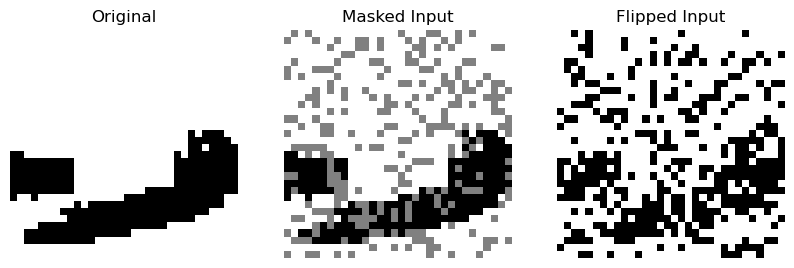

In [578]:
# Plot masked and flipped image example
plot_comparisons(spyking_patterns[0], spyking_masked[0], spyking_flipped[0],
    "Masked Input", "Flipped Input")

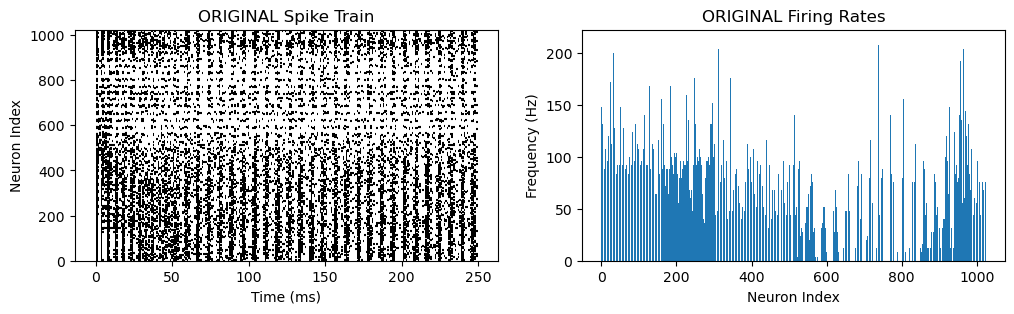

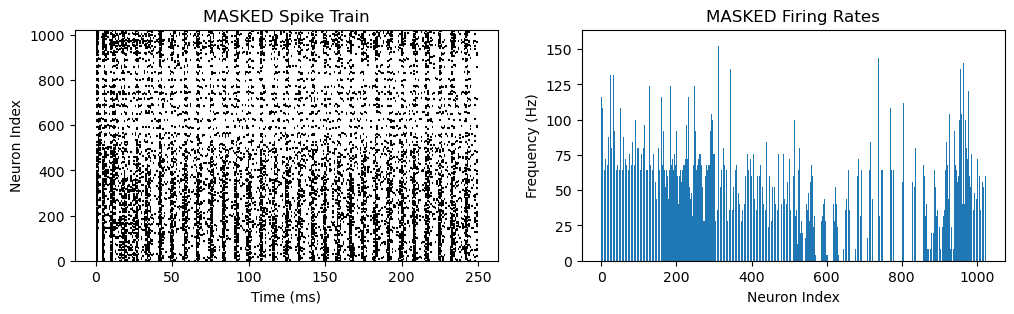

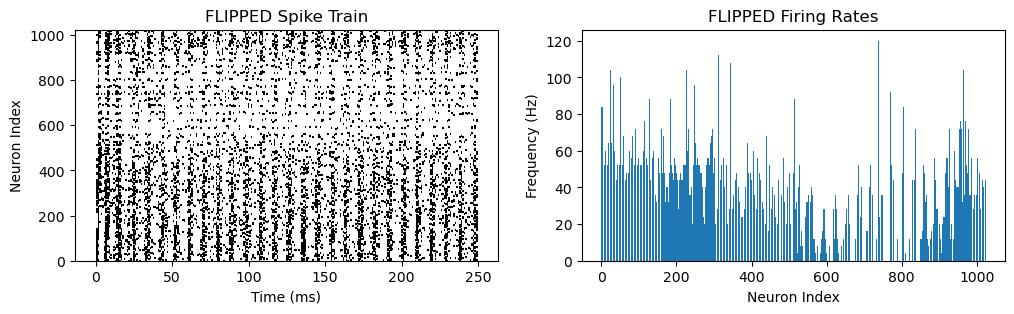

In [579]:
# Plot spiking data
plot_spiking_data(original_firings, original_rates, "ORIGINAL")
plot_spiking_data(masked_firings, masked_rates, "MASKED")
plot_spiking_data(flipped_firings, flipped_rates, "FLIPPED")

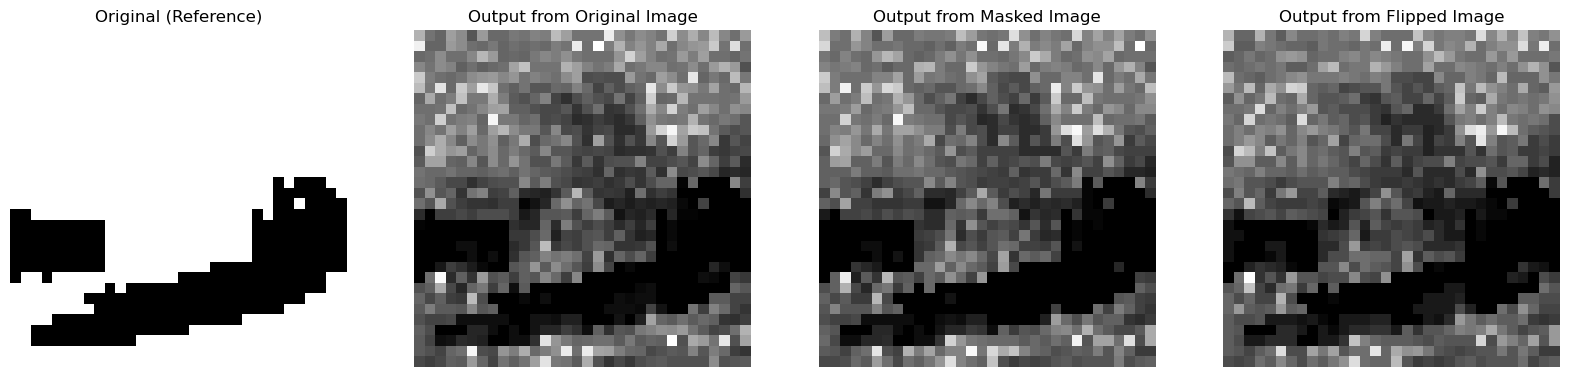

In [580]:
# Non-binarized output pattern comparison
plot_output_patterns(spyking_patterns[0], original_rates, masked_rates, flipped_rates)

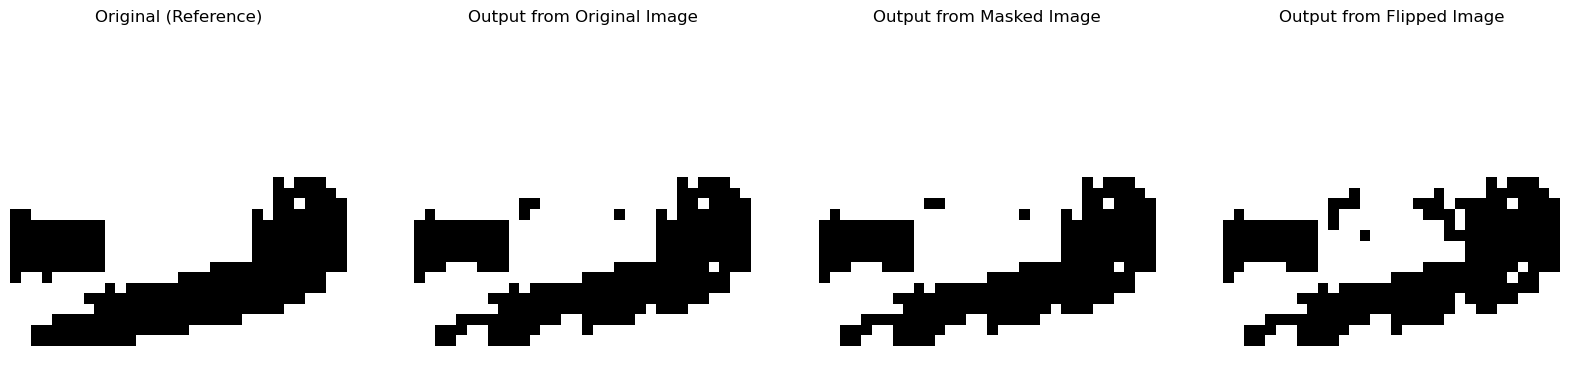

In [581]:
# Binarized output pattern comparison
plot_output_patterns(spyking_patterns[0], original_rates, masked_rates, flipped_rates, binarize=True)